In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
import cv2
import shutil
import glob

In [2]:
data = '../input/brain-mri-images-for-brain-tumor-detection/'
no_tumor = '../input/brain-mri-images-for-brain-tumor-detection/no/'
yes_tumor = '../input/brain-mri-images-for-brain-tumor-detection/yes/'

dirlist=[no_tumor, yes_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]

for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)

In [3]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')

df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])

print(df['labels'].value_counts())

df.head()

Yes    155
No      98
Name: labels, dtype: int64


,filepaths,labels
0,../input/brain-mri-images-for-brain-tumor-dete...,No
1,../input/brain-mri-images-for-brain-tumor-dete...,No
2,../input/brain-mri-images-for-brain-tumor-dete...,No
3,../input/brain-mri-images-for-brain-tumor-dete...,No
4,../input/brain-mri-images-for-brain-tumor-dete...,No


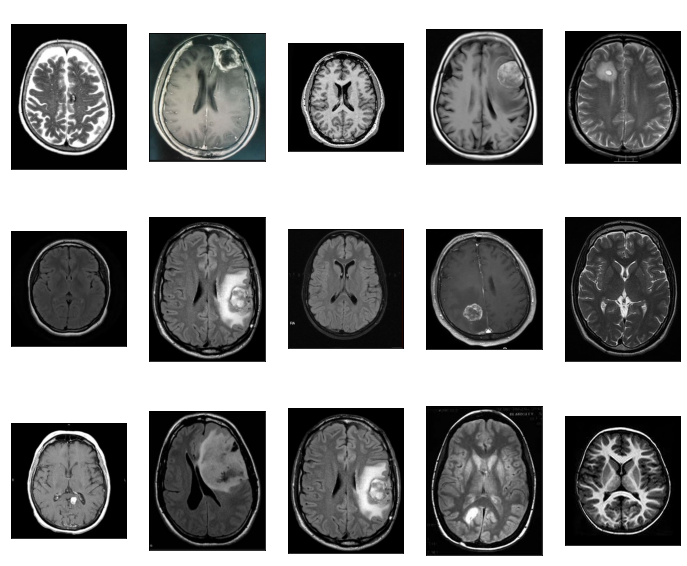

In [4]:
plt.figure(figsize=(12,10))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [6]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()


219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
N

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]

model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

history = model.fit(train_gen, validation_data = val_gen, epochs = 5, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/5
14/14 [==============================] - 27s 487ms/step - loss: 0.6450 - accuracy: 0.7604 - val_loss: 0.3709 - val_accuracy: 0.8750
Epoch 2/5
14/14 [==============================] - 3s 187ms/step - loss: 0.4407 - accuracy: 0.8610 - val_loss: 0.4612 - val_accuracy: 0.7500
Epoch 3/5
14/14 [==============================] - 3s 191ms/step - loss: 0.3000 - accuracy: 0.8768 - val_loss: 0.4552 - val_accuracy: 0.7917
Epoch 4/5
14/14 [==============================] - 3s 175ms/step - loss: 0.3547 - accuracy: 0.8751 - val_loss: 0.3862 - val_accuracy: 0.7917
Epoch 00004: early stopping


In [12]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 0s 112ms/step - loss: 0.3856 - accuracy: 0.8462


[0.3855990767478943, 0.8461538553237915]

**100% Accuracy on test set**